In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from PIL import Image


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [3]:
class AIdetec_CNN(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [4]:
dataset = AIdetec_CNN('../data', 1024)

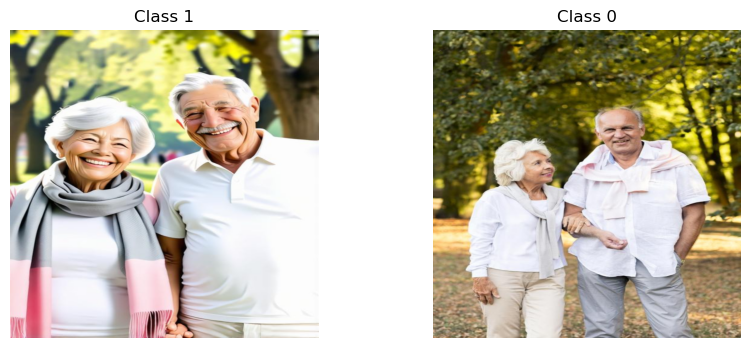

In [5]:
from torchvision.utils import make_grid

def show_examples_by_class(dataset):
    class_samples = {}
    for i in range(len(dataset)):
        img, label = dataset[i]
        if label not in class_samples:
            class_samples[label] = img
        if len(class_samples) == len(set(dataset.df["label"])):
            break

    fig, axes = plt.subplots(1, len(class_samples), figsize=(10, 4))
    for ax, (label, img) in zip(axes, class_samples.items()):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set_title(f"Class {label}")
        ax.axis("off")
    plt.show()

show_examples_by_class(dataset)

{0: 0.5654431742429733, 1: 0.588584938943386}


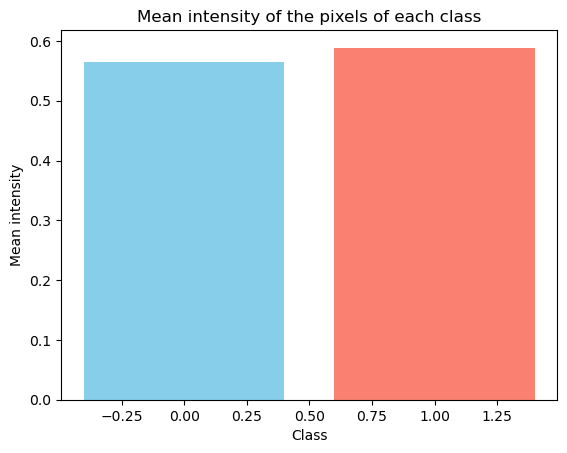

In [6]:
def mean_intensity_by_class(dataset):
    class_means = {}
    for label in sorted(dataset.df["label"].unique()):
        imgs = []
        indices = dataset.df[dataset.df["label"] == label].index
        for idx in indices[:100]:  # limitar a 100 para velocidad
            img, _ = dataset[idx]
            imgs.append(img.mean().item())
        class_means[label] = np.mean(imgs)
    return class_means

mean_intensities = mean_intensity_by_class(dataset)
print(mean_intensities)

plt.bar(mean_intensities.keys(), mean_intensities.values(), color=["skyblue", "salmon"])
plt.xlabel("Class")
plt.ylabel("Mean intensity")
plt.title("Mean intensity of the pixels of each class")
plt.show()

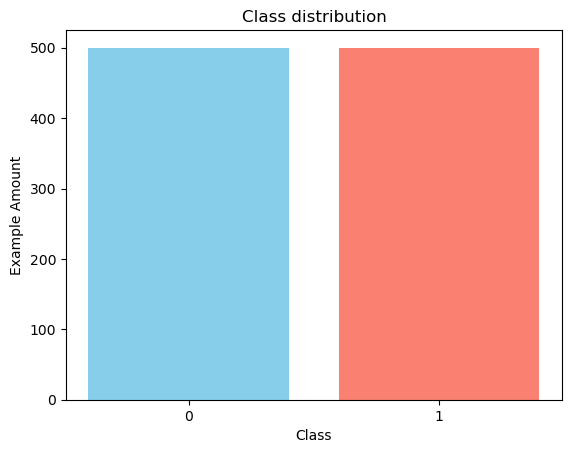

In [7]:
counts = dataset.df["label"].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values, color=["skyblue", "salmon"])
plt.xlabel("Class")
plt.ylabel("Example Amount")
plt.title("Class distribution")
plt.show()

In [8]:
print(f"Número total de imágenes: {len(dataset)}")
print(f"Clases únicas: {dataset.df['label'].unique()}")
print(f"Tamaño de una imagen: {dataset[0][0].shape}")

Número total de imágenes: 1000
Clases únicas: [1 0]
Tamaño de una imagen: torch.Size([3, 1024, 1024])


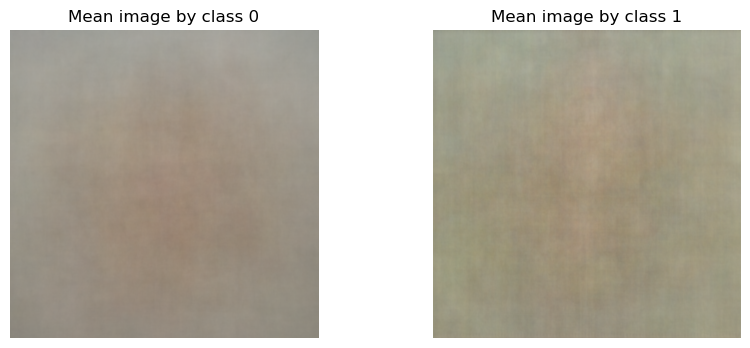

In [9]:
def average_image_by_class(dataset):
    avg_images = {}
    for label in sorted(dataset.df["label"].unique()):
        indices = dataset.df[dataset.df["label"] == label].index
        imgs_sum = torch.zeros_like(dataset[0][0])
        for idx in indices:
            img, _ = dataset[idx]
            imgs_sum += img
        avg_images[label] = imgs_sum / len(indices)
    return avg_images

avg_imgs = average_image_by_class(dataset)

# Mostrar la imagen promedio de cada clase
fig, axes = plt.subplots(1, len(avg_imgs), figsize=(10, 4))
for ax, (label, img) in zip(axes, avg_imgs.items()):
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(f"Mean image by class {label}")
    ax.axis("off")
plt.show()